**CS3320 Lab 4. Classification using KNN**

In this lab, you will look at the k-Nearest Neighbor (KNN) algorithm for classifying emails as spam or ham (normal). For email classification (spam or ham), the frequencies of a words in each email will be used as features. The euclidean distance is used to determine the similarity between two emails (compare the features); the smaller the distance, the more similar. The Euclidean Distance formula used in the algorithm is as follows:

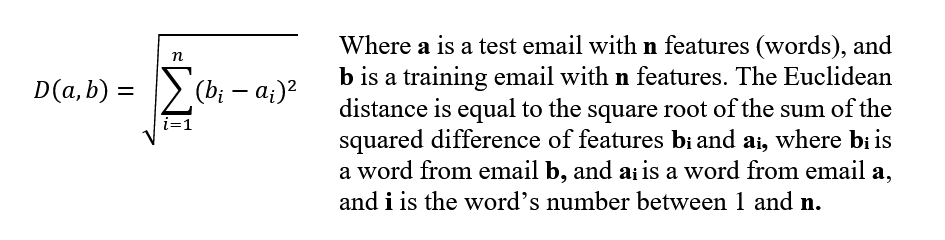

Once the Euclidean Distance between a test email and each training email is calculated, the distances are sorted in ascending order (nearest to farthest), and the K-nearest neighbouring emails are selected. If the majority is spam, then the test email is labelled as spam, else, it is labelled as ham.

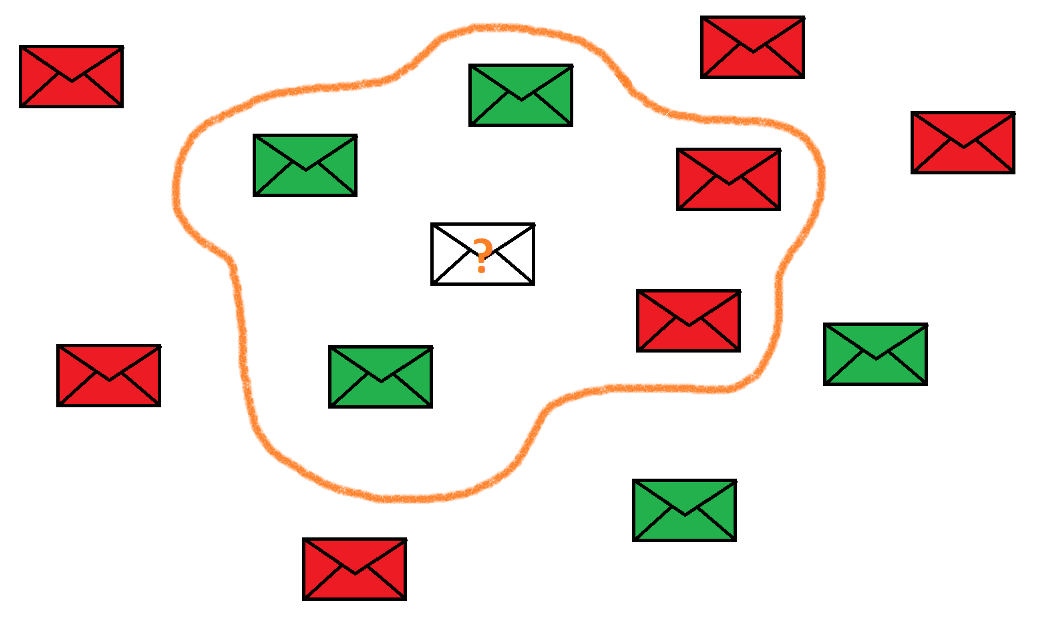

In the example shown above, K = 5; we are comparing the email we want to classify to the nearest 5 neighbours. In this case, 3 out of 5 emails are classified as ham (non-spam), and 2 are classified as spam. Therefore, the unknown email will be given the class of the majority: ham. Now let's implement the KNN!

In [54]:
import os
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**The Data Set**
The email data set for spam and ham (normal email) is obtained from “The Enron-Spam datasets”. It can be found at http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html under Enron2. The data set we are using contains 5857 emails. Every email is stored in a text file, and the text files are divided and stored into two folders, ham folder, and spam folder. This means that the emails are already labelled.

In [ ]:
!wget https://github.com/gvogiatzis/CS3320/raw/main/data/email.tar.gz
!tar -xvzf email.tar.gz

Before we do anything else, let's have a look at the dataset summary

In [41]:
!cat enron2/Summary.txt
#!cat 'enron2/spam/4201.2005-07-06.SA_and_HP.spam.txt'
#!cat 'enron2/spam/5383.2005-07-19.SA_and_HP.spam.txt'

Legitimate
----------
- Owner: kaminski-v
- Total number: 4361 emails
- Date of first email: 1999-12-10
- Date of last email: 2001-05-22
- Similars deletion: No
- Encoding: No


Spam
----
- Owner: SpamAssassin + HoneyPot
- Total number: 1496 emails
- Date of first email: 2001-05-25
- Date of last email: 2005-07-22
- Similars deletion: Yes
- Encoding: No

Spam:Legitimate rate = 1:3
Total number of emails (legitimate + spam): 5857


**Loading the Data**
Let's load the dataset in python

In [42]:
def load_data():
    print("Loading data...")
    
    ham_files_location = os.listdir("enron2/ham")
    spam_files_location = os.listdir("enron2/spam")
    data = []

    # Load ham email
    for file_path in ham_files_location:
        f = open("enron2/ham/" + file_path, "r", encoding='utf-8', errors='ignore')
        text = str(f.read())
        data.append([text, "ham"])
    
    # Load spam email
    for file_path in spam_files_location:
        f = open("enron2/spam/" + file_path, "r", encoding='utf-8', errors='ignore')
        text = str(f.read())
        data.append([text, "spam"])

    data = np.array(data)
    
    print("Data Successfully Loaded!")
    return data

Call the load data function and print the first 10 records.

In [ ]:
data = load_data()

print(data[1:10])

os.listdir() returns a list of all filenames inside a folder. This is used to retrieve all filenames of the text files in each of the ham and spam folder and store them in ham_files_location and spam_files_location respectively. data is a list to store each email text and its corresponding label.

We iterate over the list of ham text filenames, use open() to open a file, then use str(f.read()) to read the email text as a string and store it in variable text. A list made of text and the corresponding label “ham” are appended to the list data.

The list data is transformed into a numpy array, to allow better manipulation of the array later and returned.

**Data Pre-processing**

In pre-porcessing, we need to remove the punctuation and stopwords and will be using nltk.corpus library to accomplish this.


In [44]:
#Pre-processing - Removing Stopwords and Punctuations
def preprocess_data(data):
    print("Preprocessing data...")
    
    punc = string.punctuation           # Punctuation list
    sw = stopwords.words('english')     # Stopwords list
    
    for record in data:
        # Remove common punctuation and symbols
        for item in punc:
            record[0] = record[0].replace(item, "")
             
        # Lowercase all letters and remove stopwords 
        splittedWords = record[0].split()
        newText = ""
        for word in splittedWords:
            if word not in sw:
                word = word.lower()
                newText = newText + " " + word  # Takes back all non-stopwords
        record[0] = newText
        
    print("Preprocessing Complete")        
    return data

After pre-processing, the emails (dataset) will be free of stopwords and punctuations. An example (email) after pre-processing is shown below:

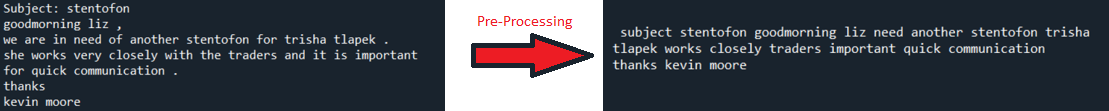

Write code to read the email ('enron2/spam/4201.2005-07-06.SA_and_HP.spam.txt'), remove the stopwords and punctuations using preprocess_data function and print the original and pre-processed data.

**Splitting the Data into Training and Testing Sets**

Let's split the data set into a training set (73%) and a testing set (27%).

In [45]:
def split_data(data):
    print("Splitting data...")
    
    features = data[:, 0]   # array containing all email text bodies
    labels = data[:, 1]     # array containing all corresponding labels
    
    training_data, test_data, training_labels, test_labels =\
        train_test_split(features, labels, test_size = 0.27, random_state = 42)
    
    print("Training and Test Data Splitted")
    return training_data, test_data, training_labels, test_labels

Let's create a function (get_count) which takes single email text as input and counts the frequency (occurrence)of each word in the email and return the word count.

In [46]:
# Get count of each word in email, returns dictionary with each word with the respective count

def get_count(text):
    wordCounts = dict()
    for word in text.split():
        if word in wordCounts:
            wordCounts[word] += 1
        else:
            wordCounts[word] = 1
    
    return wordCounts

Use the get_count function and get the word count for email ('enron2/spam/4201.2005-07-06.SA_and_HP.spam.txt') you loaded earlier.

Now, Let's create a function (euclidean_difference) which takes word counts of a test and training email and calculate the euclidean distance (as discussed in the introduction) between the test and training word counts.

In [47]:
# Get the similarity by calculating the euclidean difference, returns double

def euclidean_difference(test_WordCounts, training_WordCounts):
    total = 0
     
    for word in test_WordCounts:
        # if word is in both emails, calculate count difference, square it, and add to total
        if word in test_WordCounts and word in training_WordCounts:
            total += (test_WordCounts[word] - training_WordCounts[word])**2
            
            # to remove common words, to speed up processing in next for loop
            del training_WordCounts[word] 
            
        # if word in test email only, square the count and add to total
        else:
            total += test_WordCounts[word]**2
    
    # Square the count of words only in training email and add to total
    for word in training_WordCounts:
            total += training_WordCounts[word]**2
            
    return total**0.5


Load two emails ('enron2/spam/5383.2005-07-19.SA_and_HP.spam.txt') and ('enron2/ham/5038.2001-04-09.kaminski.ham.txt') separately and calculate the euclidean difference of above two emails with the email ('enron2/spam/4201.2005-07-06.SA_and_HP.spam.txt') and print the distance.

Let's create a function (predict_class) which takes list of the selected K nearest neighbours as input and determine the class of the current test email.

In [48]:
# Returns the class to which current email belongs to as a string

def predict_class(selected_Kvalues):
    spam_count = 0
    ham_count = 0
    
    # Counts the frequency of each class in K nearest neighbours
    for value in selected_Kvalues:
        if value[0] == "spam":
            spam_count += 1
        else:
            ham_count += 1
    
    if spam_count > ham_count:
        return "spam"
    else:
        return "ham"

Let's create KNN classifier function which takes training email, training labels, test data, the K value, and the number of test emails as input and display the predicted results.

In [49]:
# KNN classifier, returns list of labels of test_data

def knn_classifier(training_data, training_labels, test_data, K, tsize):
    print("Running KNN Classifier...")
    
    result = []
    counter = 1
    
    # word counts for training email
    training_WordCounts = [] 
    for training_text in training_data:
            training_WordCounts.append(get_count(training_text))  
            
    for test_text in test_data:
        similarity = [] # List of euclidean distances
        test_WordCounts = get_count(test_text)  # word counts for test email
        
        # Getting euclidean difference 
        for index in range(len(training_data)):
            euclidean_diff =\
                euclidean_difference(test_WordCounts, training_WordCounts[index])
            similarity.append([training_labels[index], euclidean_diff])
        
        # Sort list in ascending order based on euclidean difference
        similarity = sorted(similarity, key = lambda i:i[1])    
        
        # Select K nearest neighbours
        selected_Kvalues = [] 
        for i in range(K):
            selected_Kvalues.append(similarity[i])
            
        # Predicting the class of email
        result.append(predict_class(selected_Kvalues))
        
        print(str(counter) + "/" + str(tsize) + " done!")
        counter += 1
        
    return result


Now, let's call the functions to load the dataset, do pre-processing, generate train & test data set and predict output.

In [50]:
# Main program

def main(K):
    data = load_data()
    data = preprocess_data(data)
    training_data, test_data, training_labels, test_labels = split_data(data)
    
    # sample size of test emails to be tested. Use len(test_data) to test all test_data
    tsize = len(test_data)
    
    result = knn_classifier(training_data, training_labels, test_data[:tsize], K, tsize) 
    accuracy = accuracy_score(test_labels[:tsize], result)
    
    print("training data size\t: " + str(len(training_data)))
    print("test data size\t\t: " + str(len(test_data)))
    print("K value\t\t\t\t: " + str(K))
    print("Samples tested\t\t: " + str(tsize))
    print("% accuracy\t\t\t: " + str(accuracy * 100))
    print("Number correct\t\t: " + str(int(accuracy * tsize)))
    print("Number wrong\t\t: " + str(int((1 - accuracy) * tsize)))

In [ ]:
main(11)